# Binary Classification of Chest X-ray Images by
# ** By Y. Kostrov
***

![xray](../images/first.png)

# Overview
## In this project, I create a model that will classify x-ray image of a chest as the one that has pneumonia or the one that doesn't have pneumonia.

## During the analysis:
1. ## I will perform the necessary data wrangling first.
2. ## I will build a Baseline Model from scratch.
> * ## I will check the performance of the baseline model.
3. ## I will build a Transfer Learning Model based on the VGG19 architecture.
> * > * ## I will check the performance of the transfer learning model.
4. ## I will compare the results of the beforementioned models.

# Business Problem
## Pneumonia is a very dangerous diseases that is caused by a bacterial or viral infection of the lungs. The results of pneumonia could be catastrophic within a short period of time if not diagnosed quickly. It would be great to design a system of automatic diagnosis, capable of analyzing X-rays and help the pneumonia detection on early stages. In this project I will develop two models for the classification of chest X-ray images into NORMAL (no pneumonia) vs. PNEUMONIA(there is pneumonia in the lungs). I will recommend the model that has a better performance.

# Metrics for Assessement of Models:
1. 


***
## Importing all needed packages
***

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD 
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

***
## Define help functions
***

In [5]:
def img_class(cl):
    if np.round(cl[0]) == 1:
        return 0
    else:
        return 1 

In [6]:
#plt.style.use('fivethirtyeight') # set plotting style

In [7]:
IMAGES_LOCATION = "/home/kostrovy/data/x_ray/train" # location of images for training
TEST_IMAGES = "/home/kostrovy/data/x_ray/test" # location of images for testing
IMG_HEIGHT= 224 # set image height
IMG_WIDTH = 224 # set image size
BATCH_SIZE = 16 # set batch size

In [8]:
# Collect the paths for files used for training
files =[]
for r, d, f in os.walk(IMAGES_LOCATION):
    for file in f:
        files.append(os.path.join(r,file))

In [9]:
# Create dataframe with images for trainging to use in the Data Generator
images = pd.DataFrame(files) # dataframe
images.columns = ['path'] # set name for the column with 'path'
images['label'] = images.path.apply(lambda x:x.split('/')[-2] ) # create column with labels for each image

In [10]:
# check the shape 
images.shape #  There are 5233 images in total for training.

(5233, 2)

In [11]:
images.label.unique() # check the unique values I have in the data.

array(['train', 'NORMAL', 'PNEUMONIA'], dtype=object)

In [12]:
# somehow we have label 'train', so I will remove it.
images.drop(images[images.label=='train'].index, axis=0, inplace=True)

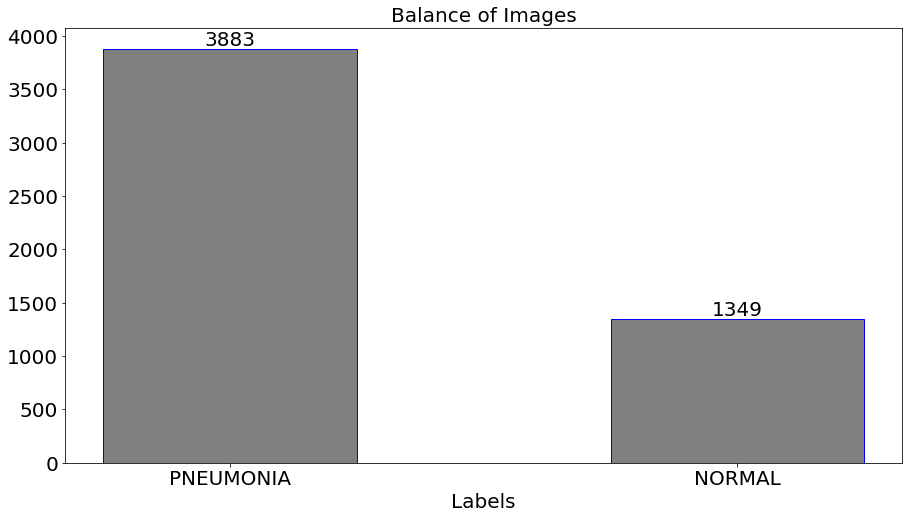

In [23]:
# Check the balance of labels in the histogram
counts = images.label.value_counts()
labels = list(counts.keys())
totals = [counts[key] for key in labels]
plt.figure(figsize=(15,8))
plt.bar(labels, totals, width= 0.5, align='center',color='gray', edgecolor = 'blue')
plt.xlabel("Labels", fontsize=20)
# Annotating the bar plot with the values (total death count)
j = 30
for i in range(len(labels)):
    plt.annotate(totals[i], ( i - 0.05, totals[i] + j),fontsize=20)
plt.title("Balance of Images")
plt.savefig("first.png")
plt.show()



## There are more images with pnemonia in this data set but the disproportion is not crazy bad
***

***
# Let's look at some pictures of normal lungs  vs lungs with pneumonia.

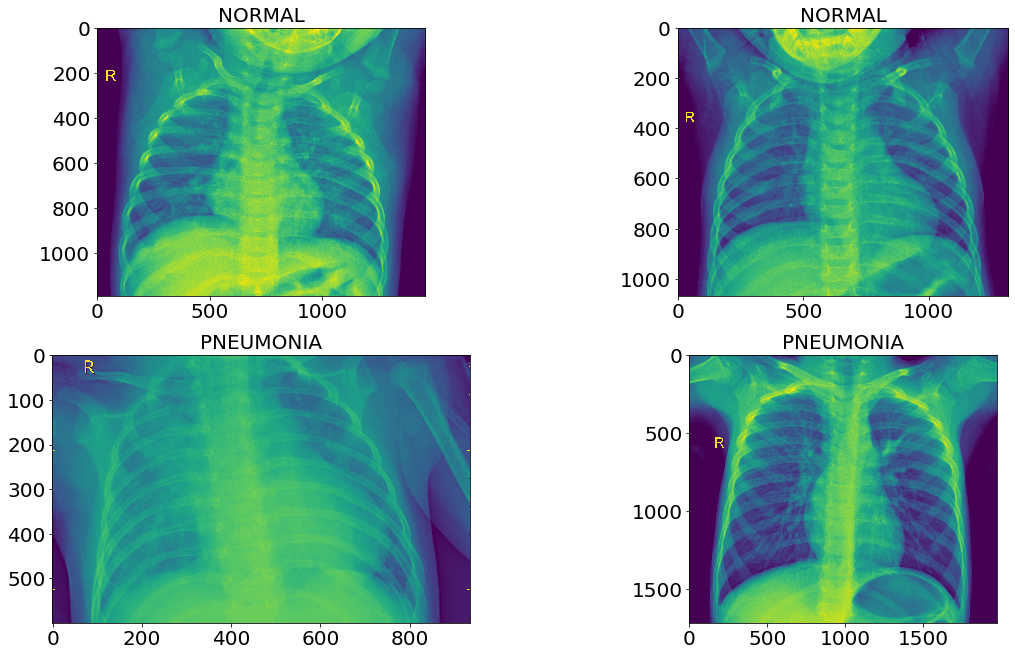

In [17]:
fig, axs = plt.subplots(2, 2,figsize=(16,9), constrained_layout=True)
for i in [0,1]:
    normal_df = images[images.label=='NORMAL']
    numb= np.random.randint(0,normal_df.shape[0])
    img = mpimg.imread(normal_df.loc[numb]['path'])
    axs[0,i].imshow(img)
    axs[0,i].set_title(normal_df.loc[numb]['label'])
for i in [0,1]:
    test_df = images[images.label=='PNEUMONIA']
    numb= np.random.randint(0,test_df.shape[0])
    img = mpimg.imread(test_df.loc[numb]['path'])
    axs[1,i].imshow(img)
    axs[1,i].set_title(test_df.loc[numb]['label'])
plt.show()

In [19]:
# Split the data frame into training and validation sets
df_train, df_test = train_test_split(images, random_state=42)
print(df_train.shape, df_test.shape)

(3924, 2) (1308, 2)


# CREATE THE SET OF TEST FILES FOR FINAL TESTING 

In [28]:
TEST_IMAGES

'/home/kostrovy/data/x_ray/test'

In [29]:
files =[]
for r, d, f in os.walk(TEST_IMAGES):
    for file in f:
        files.append(os.path.join(r,file))

In [35]:
len(files)

625

In [47]:
test_files =[]
for r, d, f in os.walk(TEST_IMAGES):
    for file in f:
        test_files.append(os.path.join(r,file))
test_images = pd.DataFrame(test_files)
test_images.columns = ['path']
test_images['label'] = test_images.path.apply(lambda x: x.split('/')[-2] )
test_images.drop(0, axis=0,inplace=True)
test_images.loc[1,'path']
img = mpimg.imread(test_images.loc[2,'path'])

In [48]:
# Check if everything went well.
test_images.label.unique()

array(['NORMAL', 'PNEUMONIA'], dtype=object)

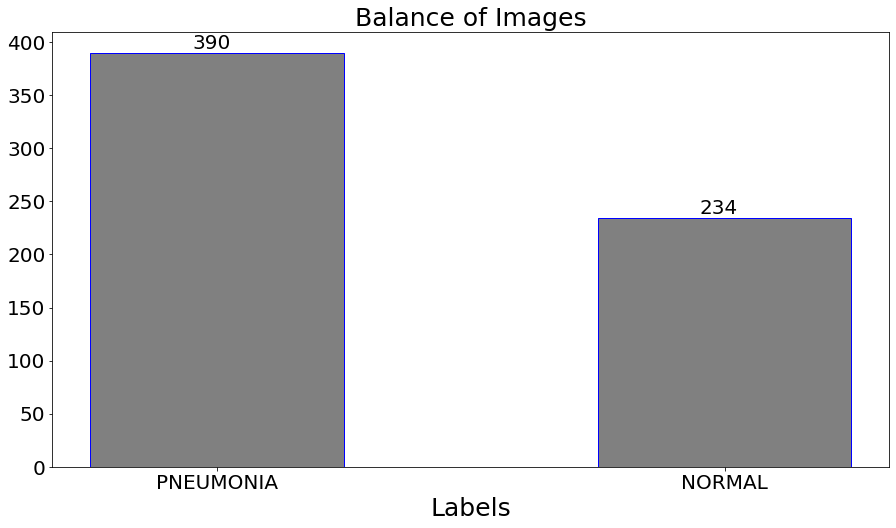

In [56]:
# Check the balance of labels in the histogram
counts = test_images.label.value_counts()
labels = list(counts.keys())
totals = [counts[key] for key in labels]
plt.figure(figsize=(15,8))
plt.bar(labels, totals, width= 0.5, align='center',color='gray', edgecolor = 'blue')
plt.xlabel("Labels", fontsize=25)
# Annotating the bar plot with the values (total death count)
for i in range(len(labels)):
    plt.annotate(totals[i], ( i - 0.05, totals[i] + 4),fontsize=20)
plt.title("Balance of Images", fontsize=25)
plt.savefig("first.png")
plt.show()


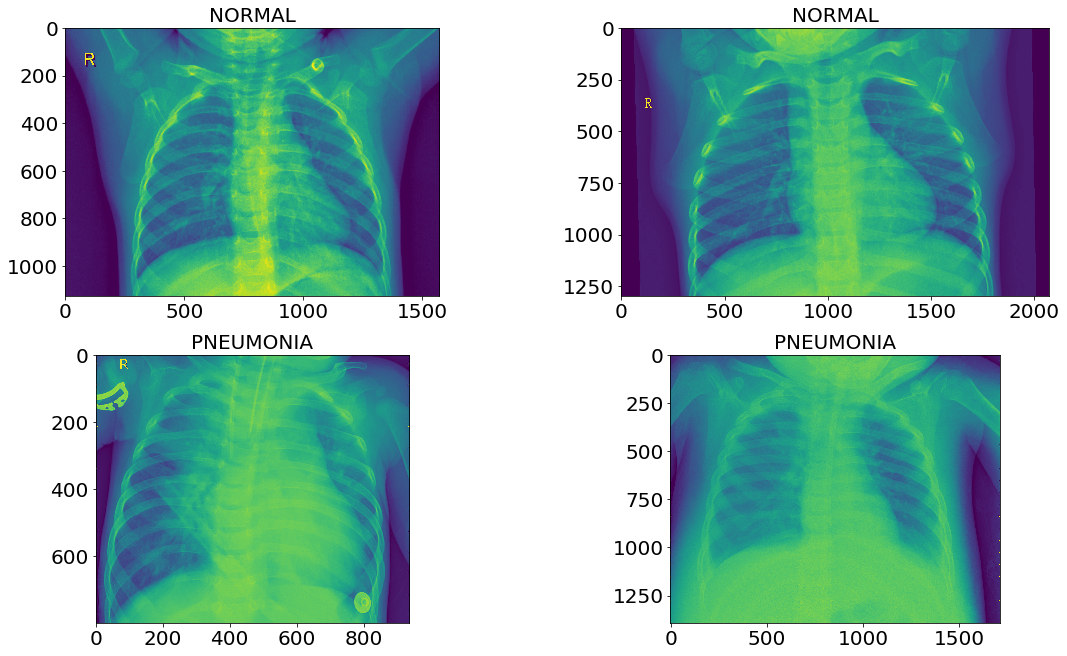

In [60]:
fig, axs = plt.subplots(2, 2,figsize=(16,9), constrained_layout=True)
for i in [0,1]:
    normal_df = test_images[test_images.label=='NORMAL']
    numb= np.random.randint(0,normal_df.shape[0])
    img = mpimg.imread(normal_df.loc[numb]['path'])
    axs[0,i].imshow(img)
    axs[0,i].set_title(normal_df.loc[numb]['label'])
for i in [0,1]:
    pnem_df = test_images[test_images.label=='PNEUMONIA']
    numb= np.random.randint(0,pnem_df.shape[0])
    img = mpimg.imread(pnem_df.loc[numb]['path'])
    axs[1,i].imshow(img)
    axs[1,i].set_title(pnem_df.loc[numb]['label'])
plt.show()

***
## Create image generator for training for regularization purposes
***

In [61]:
datagen_train = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 8,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    )

train_generator=datagen_train.flow_from_dataframe(
dataframe=df_train,
x_col="path",
y_col="label",
#subset="training",
batch_size=BATCH_SIZE,
seed=42,
#shuffle=True,
target_size=(IMG_HEIGHT,IMG_HEIGHT)
)

Found 3924 validated image filenames belonging to 2 classes.


***
## Create image generator for validation during the training process
***

In [62]:
datagen_valid = ImageDataGenerator(
    preprocessing_function = preprocess_input
)


valid_generator=datagen_valid.flow_from_dataframe(
dataframe=df_test,
x_col = "path",
y_col = "label",
#subset="validation",
batch_size = BATCH_SIZE,
seed = 42,
#shuffle=True,
#class_mode="binary",
target_size = (IMG_HEIGHT,IMG_HEIGHT)
)

Found 1308 validated image filenames belonging to 2 classes.


***
## Create image generator for final testing at the end of the training cycle
***

In [63]:
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_img_generator=datagen_test.flow_from_directory(
    TEST_IMAGES, 
    batch_size=624,
    target_size=(IMG_HEIGHT,IMG_HEIGHT),
    seed=42)

Found 624 images belonging to 2 classes.


***
## Create baseline model and train it from scratch
***

In [64]:
new_model = Sequential()
new_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_HEIGHT,3)))
new_model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(MaxPool2D(pool_size=(2,2)))
new_model.add(Dropout(0.1))
new_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(MaxPool2D(pool_size=(2,2)))
new_model.add(Dropout(0.1))
new_model.add(Conv2D(128, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(Conv2D(128, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
new_model.add(MaxPool2D(pool_size=(2,2)))
new_model.add(Dropout(0.1))
new_model.add(Flatten())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(2,activation='softmax'))

***
# Set "recall" to be the primary metric and the "accuracy" to be the secondary metric
***

In [65]:
metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Accuracy()]
new_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [92]:
EPOCHS = 30 #set number of epochs
STEPS_PER_EPOCH = 128 # set the number of steps per epochs for training
VALIDATION_STEPS = 64 # set the number of steps per epoch for validation
history = new_model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_generator,
                    validation_steps=VALIDATION_STEPS) # train

Epoch 1/30
128/128 [==============================] - 32s 253ms/step - loss: 3.5015 - recall: 0.9146 - accuracy: 0.0305 - val_loss: 3.4664 - val_recall: 0.9219 - val_accuracy: 0.0029
Epoch 2/30
128/128 [==============================] - 32s 252ms/step - loss: 3.4782 - recall: 0.9224 - accuracy: 0.0391 - val_loss: 3.4697 - val_recall: 0.9189 - val_accuracy: 4.8828e-04
Epoch 3/30
128/128 [==============================] - 32s 251ms/step - loss: 3.4546 - recall: 0.9248 - accuracy: 0.0352 - val_loss: 3.4222 - val_recall: 0.9316 - val_accuracy: 0.0044
Epoch 4/30
128/128 [==============================] - 32s 252ms/step - loss: 3.4487 - recall: 0.9160 - accuracy: 0.0403 - val_loss: 3.4141 - val_recall: 0.9326 - val_accuracy: 9.7656e-04
Epoch 5/30
128/128 [==============================] - 33s 257ms/step - loss: 3.4110 - recall: 0.9204 - accuracy: 0.0464 - val_loss: 3.3949 - val_recall: 0.9375 - val_accuracy: 0.0034
Epoch 6/30
128/128 [==============================] - 32s 253ms/step - loss: 

***
## Create a plot of Training & Validation Recalls and Traininig & Validations Loss
***

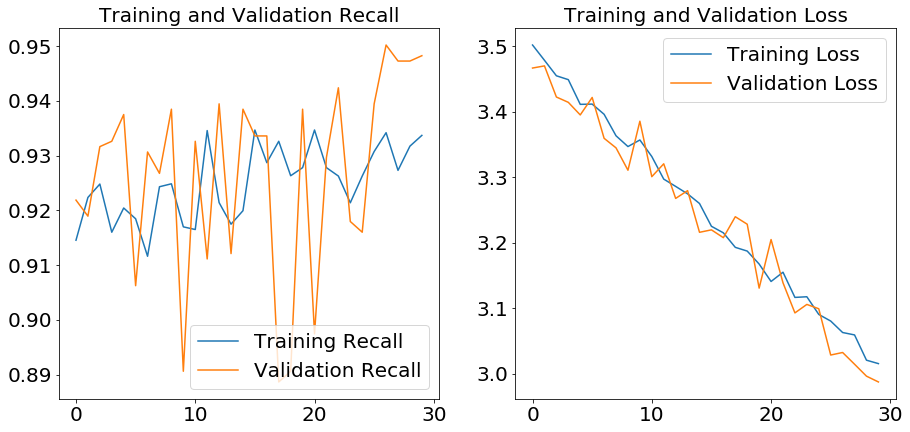

In [93]:
recall = history.history['recall']
val_recall = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***
# Let's use testing images to verify our results
***

In [94]:
preds = None
true_y = None
for i,j in test_img_generator:
    #print(len(i))
    #print(len(np.round(new_model.predict(i))))
    preds = np.round(new_model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
one_class_preds = [img_class(i) for i in preds]

print("Confusion Matrix:\n ", confusion_matrix(one_class_true_y, one_class_preds))
print("Recall Score: \n", recall_score(one_class_true_y, one_class_preds))
print("Accuracy Score: \n", accuracy_score(one_class_true_y, one_class_preds))

Confusion Matrix:
  [[175  59]
 [  6 384]]
Recall Score: 
 0.9846153846153847
Accuracy Score: 
 0.8958333333333334


***
## Let's try to use "transfer learning" since I don't have a lot of images for training, this technique should work well.
***

In [72]:
base_model = VGG19(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMG_HEIGHT,IMG_HEIGHT,3))

In [76]:
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(units=512,activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
transfer_model = Model(inputs = base_model.input, outputs=predictions)

In [77]:
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [75]:
# Fix layers for the base model as non-trainable
base_model.trainable = False

In [78]:
transfer_model.compile(optimizer=SGD(lr = 0.0001, momentum = 0.9), loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = metrics)

In [79]:
EPOCHS = 10
STEPS_PER_EPOCH = 200
VALIDATION_STEPS = 32
transfer_history = transfer_model.fit(train_generator,epochs = EPOCHS,
            steps_per_epoch = STEPS_PER_EPOCH,
            validation_data = valid_generator,
            validation_steps = VALIDATION_STEPS)

Epoch 1/10
200/200 [==============================] - 45s 215ms/step - loss: 1.1187 - recall: 0.8129 - accuracy: 0.0058 - val_loss: 0.2730 - val_recall: 0.8906 - val_accuracy: 9.7656e-04
Epoch 2/10
200/200 [==============================] - 43s 216ms/step - loss: 0.5076 - recall: 0.8532 - accuracy: 0.0359 - val_loss: 0.2694 - val_recall: 0.9043 - val_accuracy: 0.0039
Epoch 3/10
200/200 [==============================] - 43s 213ms/step - loss: 0.4012 - recall: 0.8698 - accuracy: 0.0503 - val_loss: 0.2189 - val_recall: 0.9238 - val_accuracy: 0.0078
Epoch 4/10
200/200 [==============================] - 44s 217ms/step - loss: 0.3195 - recall: 0.8975 - accuracy: 0.0607 - val_loss: 0.2275 - val_recall: 0.9199 - val_accuracy: 0.0146
Epoch 5/10
200/200 [==============================] - 43s 215ms/step - loss: 0.3086 - recall: 0.8944 - accuracy: 0.0625 - val_loss: 0.1799 - val_recall: 0.9336 - val_accuracy: 0.0107
Epoch 6/10
200/200 [==============================] - 43s 213ms/step - loss: 0.29

***
## Below, I am going to vizualize training progress by plotting training and validation recall scores and training and validation loss.

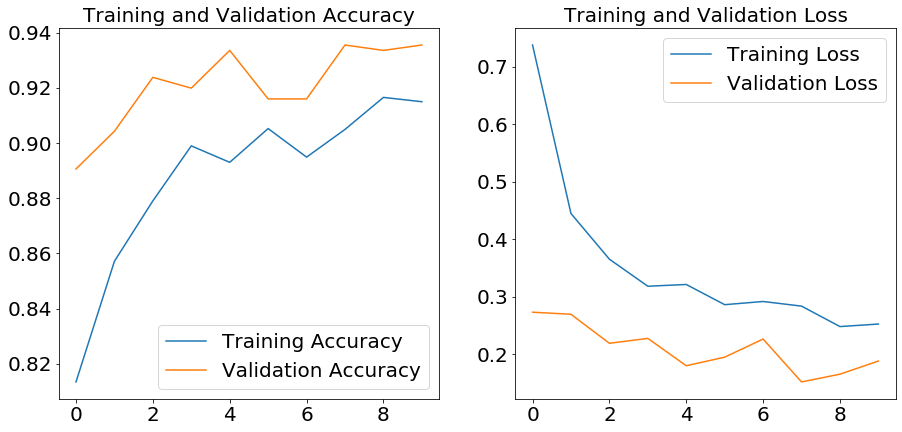

In [81]:
recall = transfer_history.history['recall']
val_recall = transfer_history.history['val_recall']
loss = transfer_history.history['loss']
val_loss = transfer_history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, recall, label='Training Accuracy')
plt.plot(epochs_range, val_recall, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

## Before I continue, let's test the model

In [83]:
preds = None
true_y = None
for i,j in test_img_generator:
    preds = np.round(transfer_model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
one_class_preds = [img_class(i) for i in preds]

print("Confusion Matrix:\n ", confusion_matrix(one_class_true_y, one_class_preds))
print("Recall Score: \n", recall_score(one_class_true_y, one_class_preds))
print("Accuracy Score: \n", accuracy_score(one_class_true_y, one_class_preds))

Confusion Matrix:
  [[207  27]
 [ 22 368]]
Recall Score: 
 0.9435897435897436
Accuracy Score: 
 0.9214743589743589


## Now we un-freeze the layers and train the whole model for 20 epochs

In [84]:
base_model.trainable = True
transfer_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [87]:
EPOCHS = 20
history = transfer_model.fit(train_generator,epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,validation_data=valid_generator,validation_steps=VALIDATION_STEPS)

Epoch 1/20
200/200 [==============================] - 44s 217ms/step - loss: 0.1523 - recall: 0.9492 - accuracy: 0.0869 - val_loss: 0.2781 - val_recall: 0.9062 - val_accuracy: 0.0820
Epoch 2/20
200/200 [==============================] - 43s 215ms/step - loss: 0.1437 - recall: 0.9482 - accuracy: 0.0961 - val_loss: 0.1905 - val_recall: 0.9297 - val_accuracy: 0.1172
Epoch 3/20
200/200 [==============================] - 43s 214ms/step - loss: 0.1079 - recall: 0.9631 - accuracy: 0.1186 - val_loss: 0.1482 - val_recall: 0.9551 - val_accuracy: 0.1064
Epoch 4/20
200/200 [==============================] - 43s 212ms/step - loss: 0.0865 - recall: 0.9705 - accuracy: 0.1509 - val_loss: 0.1773 - val_recall: 0.9434 - val_accuracy: 0.1865
Epoch 5/20
200/200 [==============================] - 43s 215ms/step - loss: 0.0762 - recall: 0.9737 - accuracy: 0.1695 - val_loss: 0.1416 - val_recall: 0.9590 - val_accuracy: 0.2471
Epoch 6/20
200/200 [==============================] - 43s 214ms/step - loss: 0.0702 -

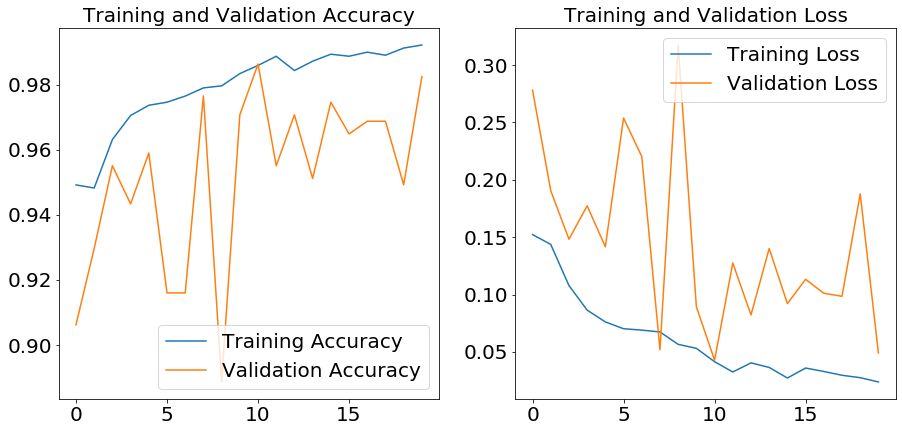

In [88]:
recall = history.history['recall']
val_recall = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, recall, label = 'Training Accuracy')
plt.plot(epochs_range, val_recall, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [91]:
preds = None
true_y = None
for i,j in test_img_generator:
    preds = np.round(transfer_model.predict(i))
    true_y = j
    break
one_class_true_y = [img_class(i) for i in true_y]
print(one_class_true_y[:10])
one_class_preds = [img_class(i) for i in preds]
print(one_class_preds[:10])

print("Confusion Matrix:\n ", confusion_matrix(one_class_true_y, one_class_preds))
print("Recall Score: \n", recall_score(one_class_true_y, one_class_preds))
print("Accuracy Score: \n", accuracy_score(one_class_true_y, one_class_preds))

[1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 1, 1, 0, 0, 0]
Confusion Matrix:
  [[206  28]
 [  2 388]]
Recall Score: 
 0.9948717948717949
Accuracy Score: 
 0.9519230769230769
